# GAN (Generative Adversarial Network)
## Генеративно-состязательная нейросеть

In [216]:
import os
import numpy as np
import math

from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision import datasets
from torch.autograd import Variable

import torch.nn as nn
import torch

########### Вывод изображений и сохранение ################################
import matplotlib.pyplot as plt
from IPython import display
from torchvision.utils import save_image, make_grid
import matplotlib.patches as mpatches
import os

os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [217]:
use_cuda = torch.cuda.is_available()
# device = torch.device("cpu")
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cpu


Домашнее задание: 

1. Как было сказано ранее, GAN обучается воспроизводить реальные данные. Поэтому Вам предлагается обучить генератор создавать точки, которые будут лежать на графике функции $y = \frac{sin(x)}{x} - \frac{x}{10}$. При выполненинии данного задания структура GAN остается той же, но Вам нужно:
 * Сгенерировать настоящие данные
 * Изменить архитектуру дискриминатора и генератора
 * Без графиков домашку не принимаю

In [152]:
x_size = 1024
start_at = 1
end_at = 10
x = np.linspace(start_at, end_at, x_size)
len(x)

1024

In [153]:
def func_y(x):
    return np.sin(x)/x - x/10
y = func_y(x)
len(y)

1024

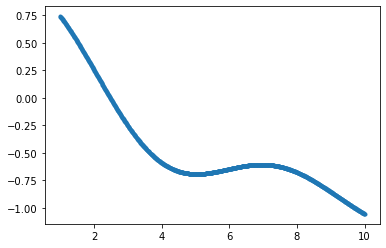

In [154]:
plt.plot(x, y, ".")

In [162]:
data_xy = torch.FloatTensor(list(zip(x, y)))
labels = torch.zeros(x_size)
dataset = list(zip(data_xy, labels))
len(dataset)

1024

In [164]:
batch_size = 32
real_data = DataLoader(
    dataset,
    batch_size=batch_size,
    shuffle=True,
)

In [206]:
n_epochs = 300
lr = 0.0002

b1 = 0.5
b2 = 0.999

latent_dim = 2
sample_interval = 25

In [207]:
for i, (imgs, labels) in enumerate(real_data):
    if i % 440 == 0:
        print(i, imgs.size())
        print(i, labels.size())

0 torch.Size([32, 2])
0 torch.Size([32])


In [208]:
class CustomLinearLayer(nn.Module):
    def __init__(self, size_in, size_out):
        super().__init__()
        self.size_in, self.size_out = size_in, size_out
        
        weights = torch.Tensor(size_out, size_in)
        self.weights = nn.Parameter(weights) 

        bias = torch.Tensor(size_out)
        self.bias = nn.Parameter(bias)

        nn.init.uniform_(self.weights, -0.005, 0.005) 
        nn.init.uniform_(self.bias, -0.005, 0.005)  

    def forward(self, x):
        w_times_x = torch.mm(x, self.weights.t())
        return torch.add(w_times_x, self.bias)  

In [209]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()

        self.model = nn.Sequential(
            nn.Linear(2, 256),
            nn.ReLU(),
            CustomLinearLayer(256, 128),
            nn.LeakyReLU(0.2, inplace=True),
            CustomLinearLayer(128, 64),
            nn.LeakyReLU(0.2, inplace=True),
            CustomLinearLayer(64, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        validity = self.model(x)
        return validity

In [210]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        
        def block(in_feat, out_feat, normalize=True): #activation='relu
            layers = [nn.Linear(in_feat, out_feat)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *block(latent_dim, 16, normalize=False),
            *block(16, 32),
            nn.Linear(32, 2),
        )

    def forward(self, z):
        res = self.model(z)
        return res

In [211]:
generator = Generator().to(device)
discriminator = Discriminator().to(device)


optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(b1, b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(b1, b2))

adversarial_loss = torch.nn.BCELoss()

In [212]:
d_loss_history = []
g_loss_history = []
xy_gen = []

In [213]:
%%time
red_patch = mpatches.Patch(color='red', label='D loss')
green_patch = mpatches.Patch(color='green', label='G loss')



for epoch in range(n_epochs):
    for i, (coord, labels) in enumerate(real_data):

        batch_size = coord.shape[0]
##################### Лейблы для данных: 1 - настоящие, 0 - сгенерированные ########
        valid = Variable(torch.FloatTensor(batch_size, 1).fill_(1.0), requires_grad=False).to(device)
        fake = Variable(torch.FloatTensor(batch_size, 1).fill_(0.0), requires_grad=False).to(device)

        real_coord = Variable(coord.type(torch.FloatTensor)).to(device)


######################  Тренировка генератора    ##########################

        optimizer_G.zero_grad()
    
        #генерация шума
        z = Variable(torch.FloatTensor(np.random.normal(start_at, end_at, (batch_size, latent_dim)))).to(device)

        gen_coord = generator(z)
        xy_gen.append(gen_coord)

        validity = discriminator(gen_coord)
        g_loss = adversarial_loss(validity, valid)
        
        g_loss.backward()
        optimizer_G.step()

######################  Тренировка дискриминатора    ##########################

        optimizer_D.zero_grad()

        real_pred = discriminator(real_coord)
        d_real_loss = adversarial_loss(real_pred, valid)

        fake_pred = discriminator(gen_coord.detach())
        d_fake_loss = adversarial_loss(fake_pred, fake)

        d_loss = (d_real_loss + d_fake_loss) / 2

        d_loss.backward()
        optimizer_D.step()
        
######## Отображение процесса обучения и вывод функций потерь ############
        batches_done = epoch * len(real_data) + i
    
        if batches_done % sample_interval == 0:
#             plt.clf()
            
#             display.clear_output(wait=False)
#             sample_image(gen_imgs)
            print("[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"% (epoch, n_epochs, i, len(real_data), d_loss.item(), g_loss.item()) ) 

            
#             display.display(plt.gcf())

            d_loss_history.append(d_loss)
            g_loss_history.append(g_loss)

#             plt.plot(np.log(np.array(d_loss_history)), label='D loss', color = 'red')
#             plt.plot(np.log(np.array(g_loss_history)), label='G loss', color = 'green')
#             plt.legend(handles=[red_patch, green_patch])
#             plt.show()

            

[Epoch 0/300] [Batch 0/32] [D loss: 0.693136] [G loss: 0.694427]
[Epoch 0/300] [Batch 25/32] [D loss: 0.578537] [G loss: 0.703033]
[Epoch 1/300] [Batch 18/32] [D loss: 0.318791] [G loss: 0.915052]
[Epoch 2/300] [Batch 11/32] [D loss: 0.168911] [G loss: 1.711598]
[Epoch 3/300] [Batch 4/32] [D loss: 0.162625] [G loss: 2.495275]
[Epoch 3/300] [Batch 29/32] [D loss: 0.185426] [G loss: 2.887357]
[Epoch 4/300] [Batch 22/32] [D loss: 0.156366] [G loss: 3.071746]
[Epoch 5/300] [Batch 15/32] [D loss: 0.133928] [G loss: 3.106514]
[Epoch 6/300] [Batch 8/32] [D loss: 0.300092] [G loss: 2.908512]
[Epoch 7/300] [Batch 1/32] [D loss: 0.152416] [G loss: 2.701557]
[Epoch 7/300] [Batch 26/32] [D loss: 0.397715] [G loss: 2.488669]
[Epoch 8/300] [Batch 19/32] [D loss: 0.285514] [G loss: 2.477088]
[Epoch 9/300] [Batch 12/32] [D loss: 0.232595] [G loss: 2.400049]
[Epoch 10/300] [Batch 5/32] [D loss: 0.266292] [G loss: 2.203903]
[Epoch 10/300] [Batch 30/32] [D loss: 0.270317] [G loss: 2.338906]
[Epoch 11/300

[Epoch 96/300] [Batch 28/32] [D loss: 0.652744] [G loss: 0.773071]
[Epoch 97/300] [Batch 21/32] [D loss: 0.638263] [G loss: 0.760083]
[Epoch 98/300] [Batch 14/32] [D loss: 0.663942] [G loss: 0.666259]
[Epoch 99/300] [Batch 7/32] [D loss: 0.575061] [G loss: 0.919415]
[Epoch 100/300] [Batch 0/32] [D loss: 0.659040] [G loss: 0.676506]
[Epoch 100/300] [Batch 25/32] [D loss: 0.671362] [G loss: 0.684362]
[Epoch 101/300] [Batch 18/32] [D loss: 0.655588] [G loss: 0.740172]
[Epoch 102/300] [Batch 11/32] [D loss: 0.653823] [G loss: 0.731900]
[Epoch 103/300] [Batch 4/32] [D loss: 0.667464] [G loss: 0.709527]
[Epoch 103/300] [Batch 29/32] [D loss: 0.633958] [G loss: 0.791105]
[Epoch 104/300] [Batch 22/32] [D loss: 0.666676] [G loss: 0.572926]
[Epoch 105/300] [Batch 15/32] [D loss: 0.649475] [G loss: 0.647801]
[Epoch 106/300] [Batch 8/32] [D loss: 0.659243] [G loss: 0.655448]
[Epoch 107/300] [Batch 1/32] [D loss: 0.647784] [G loss: 0.715592]
[Epoch 107/300] [Batch 26/32] [D loss: 0.681061] [G loss:

[Epoch 192/300] [Batch 31/32] [D loss: 0.660802] [G loss: 0.637265]
[Epoch 193/300] [Batch 24/32] [D loss: 0.617123] [G loss: 0.853389]
[Epoch 194/300] [Batch 17/32] [D loss: 0.650112] [G loss: 0.800350]
[Epoch 195/300] [Batch 10/32] [D loss: 0.658534] [G loss: 0.958015]
[Epoch 196/300] [Batch 3/32] [D loss: 0.651208] [G loss: 1.114297]
[Epoch 196/300] [Batch 28/32] [D loss: 0.637610] [G loss: 0.743661]
[Epoch 197/300] [Batch 21/32] [D loss: 0.636991] [G loss: 0.553497]
[Epoch 198/300] [Batch 14/32] [D loss: 0.632580] [G loss: 0.631986]
[Epoch 199/300] [Batch 7/32] [D loss: 0.628664] [G loss: 0.993898]
[Epoch 200/300] [Batch 0/32] [D loss: 0.651891] [G loss: 0.585316]
[Epoch 200/300] [Batch 25/32] [D loss: 0.664968] [G loss: 1.317990]
[Epoch 201/300] [Batch 18/32] [D loss: 0.641434] [G loss: 0.668075]
[Epoch 202/300] [Batch 11/32] [D loss: 0.556817] [G loss: 0.944412]
[Epoch 203/300] [Batch 4/32] [D loss: 0.635824] [G loss: 0.935980]
[Epoch 203/300] [Batch 29/32] [D loss: 0.635019] [G 

[Epoch 288/300] [Batch 9/32] [D loss: 0.652874] [G loss: 1.047531]
[Epoch 289/300] [Batch 2/32] [D loss: 0.592735] [G loss: 0.725097]
[Epoch 289/300] [Batch 27/32] [D loss: 0.586779] [G loss: 0.718244]
[Epoch 290/300] [Batch 20/32] [D loss: 0.620658] [G loss: 1.166460]
[Epoch 291/300] [Batch 13/32] [D loss: 0.570289] [G loss: 0.842539]
[Epoch 292/300] [Batch 6/32] [D loss: 0.594632] [G loss: 0.885082]
[Epoch 292/300] [Batch 31/32] [D loss: 0.626507] [G loss: 1.057925]
[Epoch 293/300] [Batch 24/32] [D loss: 0.608997] [G loss: 1.082591]
[Epoch 294/300] [Batch 17/32] [D loss: 0.606666] [G loss: 1.204040]
[Epoch 295/300] [Batch 10/32] [D loss: 0.616281] [G loss: 1.240759]
[Epoch 296/300] [Batch 3/32] [D loss: 0.628199] [G loss: 0.999091]
[Epoch 296/300] [Batch 28/32] [D loss: 0.583658] [G loss: 1.206838]
[Epoch 297/300] [Batch 21/32] [D loss: 0.597184] [G loss: 1.082306]
[Epoch 298/300] [Batch 14/32] [D loss: 0.708416] [G loss: 0.999459]
[Epoch 299/300] [Batch 7/32] [D loss: 0.617373] [G l

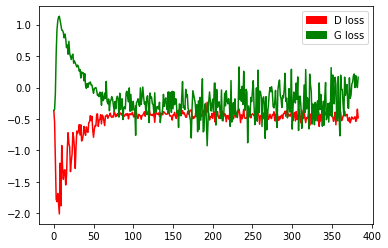

In [214]:
plt.plot(np.log(np.array(d_loss_history)), label='D loss', color = 'red')
plt.plot(np.log(np.array(g_loss_history)), label='G loss', color = 'green')
plt.legend(handles=[red_patch, green_patch])
plt.show()

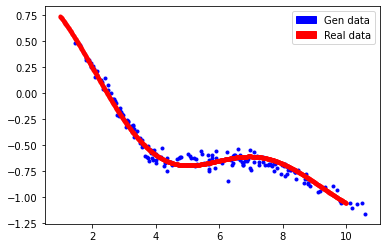

In [215]:
x_gen = []
y_gen = []
for i in range(-6, 0):
    x_gen.extend(xy_gen[i][:, 0])
    y_gen.extend(xy_gen[i][:, 1])

gen_patch = mpatches.Patch(color='blue', label='Gen data')
real_patch = mpatches.Patch(color='red', label='Real data')
plt.plot(x_gen, y_gen, ".", color = 'blue')
plt.plot(x, y, ".", color = 'red')
plt.legend(handles=[gen_patch, real_patch])
plt.show()

2. Изменить используемые модели генератора и дискриминатора, с помощью сверточных слоев. Идея: https://arxiv.org/abs/1511.06434 Датасет можно использовать так же MNIST.

In [218]:
######## функция для вывода и сохранения изображения ########
def sample_image(static_sample, save_img = False):
    npimg = make_grid(static_sample.data[:25]).cpu().numpy()
    fig, ax = plt.subplots(figsize=(7, 7))
    ax.imshow(np.transpose(npimg, (1,2,0)), interpolation="nearest")
    if save_img:
        save_image(gen_imgs.data[:25], "images/%d.png" % batches_done, nrow=5, normalize=True)

Параметры для обучения обеих моделей

In [235]:
n_epochs = 15
batch_size = 64
lr = 0.0002

b1 = 0.5
b2 = 0.999

latent_dim = 100

n_classes = 10
img_size = 28
channels = 1

sample_interval = 25

img_shape = (channels, img_size, img_size)

Генератор

In [236]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        
        def block(in_feat, out_feat, normalize=True): #activation='relu
            layers = [nn.Linear(in_feat, out_feat)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *block(latent_dim, 128, normalize=False),
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, int(np.prod(img_shape))),
            nn.Tanh()
        )
#         self.activations = nn.ModuleDict([
#                 ['lrelu', nn.LeakyReLU()],
#                 ['relu', nn.ReLU()]])

    def forward(self, z):
        img = self.model(z)
        img = img.view(img.size(0), *img_shape)
        return img

#### ... Небольшое отступление 
Создание своих слоев

In [238]:
class CustomLinearLayer(nn.Module):
    def __init__(self, size_in, size_out):
        super().__init__()
        self.size_in, self.size_out = size_in, size_out
        
        weights = torch.Tensor(size_out, size_in)
        self.weights = nn.Parameter(weights) 

        bias = torch.Tensor(size_out)
        self.bias = nn.Parameter(bias)

        nn.init.uniform_(self.weights, -0.005, 0.005) 
        nn.init.uniform_(self.bias, -0.005, 0.005)  

    def forward(self, x):
        w_times_x = torch.mm(x, self.weights.t())
        return torch.add(w_times_x, self.bias)  

#### nn.init
https://pytorch.org/docs/stable/nn.init.html

Дискриминатор 

In [239]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()

        self.model = nn.Sequential(
            CustomLinearLayer(int(np.prod(img_shape)), 512),
            nn.LeakyReLU(0.2, inplace=True),
            CustomLinearLayer(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            CustomLinearLayer(256, 1),
            nn.Sigmoid(),
        )
  

    def forward(self, img):
        img_flat = img.view(img.size(0), -1)
        validity = self.model(img_flat)

        return validity

Загрузка датасета

In [240]:
real_data = DataLoader(
    datasets.MNIST(
        "../../data/mnist",
        train=True,
        download=False,
        transform=transforms.Compose(
            [transforms.Resize(img_size), transforms.ToTensor(), transforms.Normalize([0.5], [0.5])]
        ),
    ),
    batch_size=batch_size,
    shuffle=True,
)

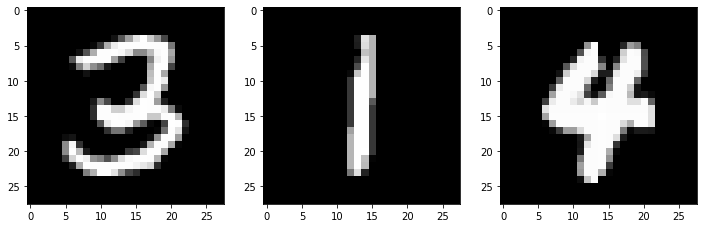

In [241]:
dataiter = iter(real_data)
images, labels = dataiter.next()
images = images.numpy()

img = np.squeeze(images[0])
img1 = np.squeeze(images[1])
img2 = np.squeeze(images[2])

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (12,4))
ax1.imshow(img, cmap='gray')
ax2.imshow(img1, cmap='gray')
ax3.imshow(img2, cmap='gray')

Инициализация

In [242]:
generator = Generator().to(device)
discriminator = Discriminator().to(device)


optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(b1, b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(b1, b2))

adversarial_loss = torch.nn.BCELoss()

In [243]:
d_loss_history = []
g_loss_history = []

In [244]:
len(real_data)

938

In [245]:
%%time
red_patch = mpatches.Patch(color='red', label='D loss')
green_patch = mpatches.Patch(color='green', label='G loss')



for epoch in range(n_epochs):
    for i, (imgs, labels) in enumerate(real_data):

        batch_size = imgs.shape[0]
##################### Лейблы для данных: 1 - настоящие, 0 - сгенерированные ########
        valid = Variable(torch.FloatTensor(batch_size, 1).fill_(1.0), requires_grad=False).to(device)
        fake = Variable(torch.FloatTensor(batch_size, 1).fill_(0.0), requires_grad=False).to(device)

        real_imgs = Variable(imgs.type(torch.FloatTensor)).to(device)


######################  Тренировка генератора    ##########################

        optimizer_G.zero_grad()
    
        #генерация шума
        z = Variable(torch.FloatTensor(np.random.normal(0, 1, (batch_size, latent_dim)))).to(device)

        gen_imgs = generator(z)

        validity = discriminator(gen_imgs)
        g_loss = adversarial_loss(validity, valid)
        
        g_loss.backward()
        optimizer_G.step()

######################  Тренировка дискриминатора    ##########################

        optimizer_D.zero_grad()

        real_pred = discriminator(real_imgs)
        d_real_loss = adversarial_loss(real_pred, valid)

        fake_pred = discriminator(gen_imgs.detach())
        d_fake_loss = adversarial_loss(fake_pred, fake)

        d_loss = (d_real_loss + d_fake_loss) / 2

        d_loss.backward()
        optimizer_D.step()
        
######## Отображение процесса обучения и вывод функций потерь ############
        batches_done = epoch * len(real_data) + i
    
        if batches_done % sample_interval == 0:
#             plt.clf()
            
#             display.clear_output(wait=False)
#             sample_image(gen_imgs)
#             print("[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"% (epoch, n_epochs, i, len(real_data), d_loss.item(), g_loss.item()) ) 

            
#             display.display(plt.gcf())

            d_loss_history.append(d_loss)
            g_loss_history.append(g_loss)

#             plt.plot(np.log(np.array(d_loss_history)), label='D loss', color = 'red')
#             plt.plot(np.log(np.array(g_loss_history)), label='G loss', color = 'green')
#             plt.legend(handles=[red_patch, green_patch])
#             plt.show()

            

Wall time: 13min 59s


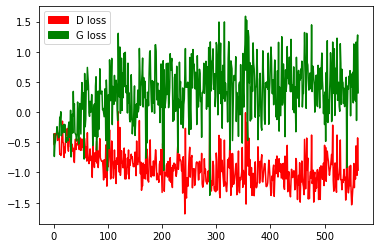

In [246]:
plt.plot(np.log(np.array(d_loss_history)), label='D loss', color = 'red')
plt.plot(np.log(np.array(g_loss_history)), label='G loss', color = 'green')
plt.legend(handles=[red_patch, green_patch])
plt.show()

In [259]:
print('last loss discriminator')
for i in range(-5, 0):
    print(d_loss_history[i])
print('last loss generator')
for i in range(-5, 0):
    print(g_loss_history[i])

last loss discriminator
tensor(0.5719, grad_fn=<DivBackward0>)
tensor(0.5225, grad_fn=<DivBackward0>)
tensor(0.3515, grad_fn=<DivBackward0>)
tensor(0.6528, grad_fn=<DivBackward0>)
tensor(0.3825, grad_fn=<DivBackward0>)
last loss generator
tensor(3.1883, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.8708, grad_fn=<BinaryCrossEntropyBackward>)
tensor(2.9928, grad_fn=<BinaryCrossEntropyBackward>)
tensor(3.5917, grad_fn=<BinaryCrossEntropyBackward>)
tensor(1.3777, grad_fn=<BinaryCrossEntropyBackward>)


### Реализация со сверточными слоями:

In [266]:
n_epochs = 5
batch_size = 64
lr = 0.0002

b1 = 0.5
b2 = 0.999

latent_dim = 100

n_classes = 10
img_size = 28
channels = 1

sample_interval = 25

img_shape = (channels, img_size, img_size)

In [285]:
latent_dim

100

In [317]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()

        self.model = nn.Sequential(

        nn.ConvTranspose2d(latent_dim, 1024, kernel_size=4, stride=1, padding=0, bias=False),
        nn.BatchNorm2d(1024),
        nn.ReLU(True),

        nn.ConvTranspose2d(1024, 512, kernel_size=4, stride=1, padding=1, bias=False),
        nn.BatchNorm2d(512),
        nn.ReLU(True),

        nn.ConvTranspose2d(512, 264, kernel_size=4, stride=1, padding=1, bias=False),
        nn.BatchNorm2d(264),
        nn.ReLU(True),

        nn.ConvTranspose2d(264, 128, kernel_size=4, stride=1, padding=1, bias=False),
        nn.BatchNorm2d(128),
        nn.ReLU(True),

        nn.ConvTranspose2d(128, 64, kernel_size=4, stride=1, padding=1, bias=False),
        nn.BatchNorm2d(64),
        nn.ReLU(True),

        nn.ConvTranspose2d(64, 1, kernel_size=4, stride=1, padding=1, bias=False),
        nn.Tanh()
    )

    def forward(self, z):
        img = self.model(z)
#         img = img.view(img.size(0), *img_shape)
        return img

In [318]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()

        self.model = nn.Sequential(
            nn.ConvTranspose2d(int(np.prod(img_shape)), 512, kernel_size=4, stride=1, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=1, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose2d(256, 1, kernel_size=4, stride=1, padding=0, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Sigmoid()
        )
  
    def forward(self, img):
#         img = img.view(img.size(0), -1)
        validity = self.model(img)

        return validity

In [319]:
generator = Generator().to(device)
discriminator = Discriminator().to(device)


optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(b1, b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(b1, b2))

adversarial_loss = torch.nn.BCELoss()

In [320]:
d_loss_history = []
g_loss_history = []

In [315]:
len(real_data)

938

In [307]:
for i, (imgs, labels) in enumerate(real_data):
    if i%600==0:
        print(i, imgs.size(), labels.size())
        a = imgs

0 torch.Size([64, 1, 28, 28]) torch.Size([64])
600 torch.Size([64, 1, 28, 28]) torch.Size([64])


In [308]:
a.size()

torch.Size([64, 1, 28, 28])

In [309]:
b = Variable(a.type(torch.FloatTensor)).to(device)
b.size()

torch.Size([64, 1, 28, 28])

In [321]:
%%time
red_patch = mpatches.Patch(color='red', label='D loss')
green_patch = mpatches.Patch(color='green', label='G loss')



for epoch in range(n_epochs):
    for i, (imgs, labels) in enumerate(real_data):

        batch_size = imgs.shape[0]
##################### Лейблы для данных: 1 - настоящие, 0 - сгенерированные ########
        valid = Variable(torch.FloatTensor(batch_size, 1).fill_(1.0), requires_grad=False).to(device)
        fake = Variable(torch.FloatTensor(batch_size, 1).fill_(0.0), requires_grad=False).to(device)

        real_imgs = Variable(imgs.type(torch.FloatTensor)).to(device)


######################  Тренировка генератора    ##########################

        optimizer_G.zero_grad()
    
        #генерация шума
#         z = Variable(torch.FloatTensor(np.random.normal(0, 1, (batch_size, 1, 4, 4)))).to(device)
        z = torch.randn(batch_size, latent_dim, 1, 1, device=device)
        gen_imgs = generator(z)

        validity = discriminator(gen_imgs)
        g_loss = adversarial_loss(validity, valid)
        
        g_loss.backward()
        optimizer_G.step()

######################  Тренировка дискриминатора    ##########################

        optimizer_D.zero_grad()

        real_pred = discriminator(real_imgs)
        d_real_loss = adversarial_loss(real_pred, valid)

        fake_pred = discriminator(gen_imgs.detach())
        d_fake_loss = adversarial_loss(fake_pred, fake)

        d_loss = (d_real_loss + d_fake_loss) / 2

        d_loss.backward()
        optimizer_D.step()
        
######## Отображение процесса обучения и вывод функций потерь ############
        batches_done = epoch * len(real_data) + i
    
        if batches_done % sample_interval == 0:
#             plt.clf()
            
#             display.clear_output(wait=False)
#             sample_image(gen_imgs)
#             print("[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"% (epoch, n_epochs, i, len(real_data), d_loss.item(), g_loss.item()) ) 

            
#             display.display(plt.gcf())

            d_loss_history.append(d_loss)
            g_loss_history.append(g_loss)

#             plt.plot(np.log(np.array(d_loss_history)), label='D loss', color = 'red')
#             plt.plot(np.log(np.array(g_loss_history)), label='G loss', color = 'green')
#             plt.legend(handles=[red_patch, green_patch])
#             plt.show()

            

RuntimeError: Given transposed=1, weight of size [784, 512, 4, 4], expected input[64, 1, 9, 9] to have 784 channels, but got 1 channels instead

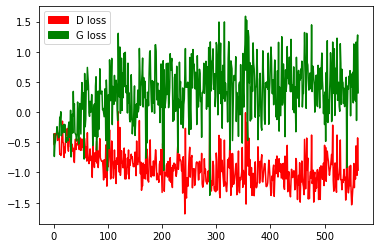

In [246]:
plt.plot(np.log(np.array(d_loss_history)), label='D loss', color = 'red')
plt.plot(np.log(np.array(g_loss_history)), label='G loss', color = 'green')
plt.legend(handles=[red_patch, green_patch])
plt.show()

https://medium.com/@jonathan_hui